In [1]:
# load ♎
import os; import pandas as pd; import numpy as np; import librosa; import pydub

In [2]:
os.listdir('../input/hausa-audio-corpus-v8')

['test_dataset', 'train.tsv', 'SampleSubmission.csv', 'clips', 'Test.csv']

In [3]:
!pip install jiwer

In [4]:
mp_path = '../input/hausa-audio-corpus-v8/clips/clips/'
tsv_path = '../input/hausa-audio-corpus-v8'
test_mp_path = '../input/hausa-audio-corpus-v8/test_dataset/test_dataset/'
csv_path = '../input/hausa-audio-corpus-v8/Test.csv'

In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer

In [6]:
train = pd.read_csv(f'{tsv_path}/train.tsv', sep='\t')
train = train[['path', 'sentence']]
train.head(5)


,path,sentence
0,common_voice_ha_26692998.mp3,Falmata ta rufe kanta a ɗakinta tana kuka kusa...
1,common_voice_ha_26693002.mp3,An tuhumi Hassan da fitar da wasu muhimman bay...
2,common_voice_ha_26693005.mp3,Georege ya zana da'ira da sanda.
3,common_voice_ha_26693006.mp3,Tana karatun digiri ne na Ivy League.
4,common_voice_ha_26693872.mp3,Abdullahi ya ce Zulai ba ta da tabbacin ko Has...


In [7]:
import sndhdr
print(sndhdr.whathdr(f'{mp_path}common_voice_ha_26693872.mp3'))

None


In [8]:
import librosa
librosa.get_duration(filename=f'{mp_path}common_voice_ha_26693872.mp3')

5.9

In [9]:
import librosa
librosa.get_samplerate(f'{mp_path}common_voice_ha_26693872.mp3')

32000

In [10]:
librosa.get_samplerate(f'{mp_path}common_voice_ha_26693005.mp3')

32000

In [11]:
test_df = pd.read_csv(csv_path)
test_df.head()

,Clip_ID,Client_ID,up_votes,down_votes
0,ID_CL82BUTY,jfk3tof013s6,2,0
1,ID_YB937R4N,lt63h93zstzb,2,0
2,ID_0ETZSY8G,q9gujl5xdvzf,2,0
3,ID_1SAQR925,q9gujl5xdvzf,2,0
4,ID_ELCZ729F,jfk3tof013s6,2,0


In [12]:
from sklearn.model_selection import train_test_split
df_train1, df_val = train_test_split(train, test_size=0.13, random_state=42)

print(f"Size of the training set: {len(df_train1)}")
print(f"Size of the validation set: {len(df_val)}")


Size of the training set: 1688
Size of the validation set: 253


In [13]:
df_train = pd.concat([df_train1.copy(), df_val[:len(df_val)-50]])
print(f"Size of the training set: {len(df_train)}")
print(f"Size of the validation set: {len(df_val)}")

Size of the training set: 1891
Size of the validation set: 253


# Preprocessing

In [14]:
# The set of characters accepted in the transcription.
characters = [x for x in "abcdefghijklmnopqrstuvwxyz' "]
# Mapping characters to integers
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")
# Mapping integers back to original characters
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

2022-02-12 22:00:43.178463: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", ' '] (size =29)


2022-02-12 22:00:43.283522: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-12 22:00:43.284300: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-12 22:00:43.286101: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-12 22:00:43.287134: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [15]:
# An integer scalar Tensor. The window length in samples.
frame_length = 256
# An integer scalar Tensor. The number of samples to step.
frame_step = 320
# An integer scalar Tensor. The size of the FFT to apply.
# If not provided, uses the smallest power of 2 enclosing frame_length.
fft_length = 384


def encode_single_sample(audio_file, label):
    ###########################################
    ##  Process the Audio
    ##########################################
    # 1. Read mp3 file
    file = tf.io.read_file(mp_path + audio_file)
    # 2. Decode the wav file
    audio = tfio.audio.decode_mp3(file)
    audio = tf.squeeze(audio, axis=-1)
    # 3. Change type to float
    audio = tf.cast(audio, tf.float32)
    # 4. Get the spectrogram
    spectrogram = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )
    # 5. We only need the magnitude, which can be derived by applying tf.abs
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)
    # 6. normalisation
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)
    ###########################################
    ##  Process the label
    ##########################################
    # 7. Convert label to Lower case
    label = tf.strings.lower(label)
    # 8. Split the label
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    # 9. Map the characters in label to numbers
    label = char_to_num(label)
    # 10. Return a dict as our model is expecting two inputs
    return spectrogram, label

In [16]:
def test_encode_single_sample(audio_file):
    ###########################################
    ##  Process the Audio
    ##########################################
    # 1. Read  file
    file = tf.io.read_file(test_mp_path + audio_file + ".mp3")
    # 2. Decode the mp3 file
    audio = tfio.audio.decode_mp3(file)
    audio = tf.squeeze(audio, axis=-1)
    # 3. Change type to float
    audio = tf.cast(audio, tf.float32)
    # 4. Get the spectrogram
    spectrogram = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )
    # 5. We only need the magnitude, which can be derived by applying tf.abs
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)
    # 6. normalisation
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)
    ###########################################
    ##  Process the label
    ###################################
    # 10. Return a dict as our model is expecting two inputs
    return spectrogram

# Tensorflow Data

In [17]:
batch_size = 32
# Define the trainig dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train["path"]), list(df_train["sentence"]))
)
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Define the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["path"]), list(df_val["sentence"]))
)
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

2022-02-12 22:00:45.882160: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 AVX512F FMA


In [18]:
batch_size = 32

# Define the validation dataset
test_dataset = tf.data.Dataset.from_tensor_slices(
    (list(test_df["Clip_ID"]))
)
test_dataset = (
    test_dataset.map(test_encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Visualization

2022-02-12 22:00:46.888222: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


(875, 193)


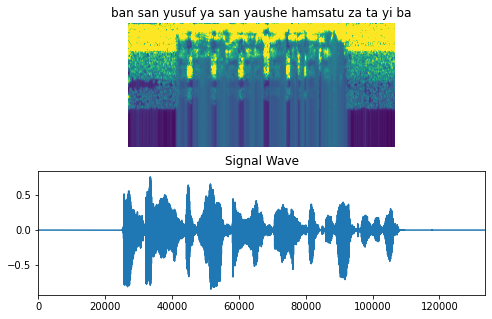

In [19]:
fig = plt.figure(figsize=(8, 5))
for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    print(spectrogram.shape)
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]
    # Spectrogram
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")
    # mp3
    file = tf.io.read_file(mp_path + list(df_train["path"])[0])
    audio = tfio.audio.decode_mp3(file)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=33000))
plt.show()

# Model

In [20]:
def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [21]:
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
    """Model similar to DeepSpeech2."""
    # Model's input
    input_spectrogram = layers.Input((None, input_dim), name="input")
    # Expand the dimension to use 2D CNN.
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)
    # Convolution layer 1
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 41],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1",
    )(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)
    # Convolution layer 2
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 21],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_2",
    )(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)
    # Reshape the resulted volume to feed the RNNs layers
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
    # RNN layers
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}",
        )
        x = layers.Bidirectional(
            recurrent, name=f"bidirectional_{i}", merge_mode="concat"
        )(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)
    # Dense layer
    x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x = layers.ReLU(name="dense_1_relu")(x)
    x = layers.Dropout(rate=0.5)(x)
    # Classification layer
    output = layers.Dense(units=output_dim + 1, activation="softmax")(x)
    # Model
    model = keras.Model(input_spectrogram, output, name="DeepSpeech_2")
    # Optimizer
    opt = keras.optimizers.Adam(learning_rate=1e-4)
    # Compile the model and return
    model.compile(optimizer=opt, loss=CTCLoss)
    return model


# Get the model
model = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512,
)

# Training

In [22]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=False, beam_width=100)[0][0]
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text


# A callback class to output a few transcriptions during training
class CallbackEval(keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (
                    tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                )
                targets.append(label)
        wer_score = wer(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print("-" * 100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)

In [23]:
print("Welcome to ASR model training!")

Welcome to ASR model training!


In [24]:
# Define the number of epochs.
epochs = 80

# Callback function to check transcription on the val set.
validation_callback = CallbackEval(validation_dataset)
# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)

Epoch 1/80


2022-02-12 22:01:09.341365: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


60/60 [==============================] - 229s 3s/step - loss: 160.7661 - val_loss: 138.3172
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.9800
----------------------------------------------------------------------------------------------------
Target    : babangida ya shirya don shiga cikin madauki
Prediction: a
----------------------------------------------------------------------------------------------------
Target    : ina ganin zan iya magana da faransanci kamar yadda ibrahim zai yi
Prediction: a
----------------------------------------------------------------------------------------------------
Epoch 2/80
60/60 [==============================] - 187s 3s/step - loss: 119.6817 - val_loss: 141.0726
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.9800
------------------------------------------------------------------------------------------

# Inference

In [25]:
# Let's check results on more validation samples
predictions = []
targets = []
for batch in validation_dataset:
    X, y = batch
    batch_predictions = model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label)
wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)
for i in np.random.randint(0, len(predictions), 5):
    print(f"Target    : {targets[i]}")
    print(f"Prediction: {predictions[i]}")
    print("-" * 100)

----------------------------------------------------------------------------------------------------
Word Error Rate: 0.2470
----------------------------------------------------------------------------------------------------
Target    : a lokutan rashin lafiya samun isasshen bacci shine mafi kyawun magani
Prediction: a lokotar rashin lafiya samin yi sashin banci she ne marfikyawon ma agane
----------------------------------------------------------------------------------------------------
Target    : ibrahim ya yi tafiya zuwa gabacin asar
Prediction: ibrahimi ya yi tafiya zuwa gabacin kasar
----------------------------------------------------------------------------------------------------
Target    : na yi kewar ku sosai
Prediction: na yi kewar ku sosai
----------------------------------------------------------------------------------------------------
Target    : fusatattun matasan sun kaiwa ginin hari
Prediction: fusatatun matasan sun kaiwa ginin hari
------------------------------

In [26]:
# Let's check results on more validation samples
predictions = []
for batch in test_dataset:
    X = batch
    batch_predictions = model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)

for i in np.random.randint(0, len(predictions), 5):
    print(f"Prediction: {predictions[i]}")
    print("-" * 100)

Prediction: aba bar ru de biri dorb firutar dousha
----------------------------------------------------------------------------------------------------
Prediction:  ba bilite wafi bar kin yuwouo fato tanwa yi hifi
----------------------------------------------------------------------------------------------------
Prediction: intfiry ba ron tibfilan
----------------------------------------------------------------------------------------------------
Prediction:  dursale rshir fan fe tayishirwa buna ibushnkeal lira
----------------------------------------------------------------------------------------------------
Prediction: ace ma runi fi fiin geami
----------------------------------------------------------------------------------------------------


# Submission

In [27]:
sub = pd.DataFrame({'ID': list(test_df['Clip_ID']), 'Transcription': predictions})
sub.to_csv('df_1.csv', index=False)
sub.head()

,ID,Transcription
0,ID_CL82BUTY,t a ain girla yiyanr kuturlai bawari yerkarshi...
1,ID_YB937R4N,ausi doen ci tsor tal si mo gi on o
2,ID_0ETZSY8G,yinan biya fiyanke ki
3,ID_1SAQR925,ga yi junanin zan sa me yakojin
4,ID_ELCZ729F,tiybuna ho tar wa surar rawashi cin yar shiyi ...


In [28]:
# saving the model in tensorflow format
model.save('./DeepSpeech_1')


# loading the saved model
loaded_model = tf.saved_model.load('./DeepSpeech_1')

2022-02-13 03:06:07.176187: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
